In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

seed_value = 10 #random seed representing our AI4ALL group no.  
random.seed(seed_value)

# 1. Loading in Data

In [18]:
class FoodImageDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def get_class_counts(self): 
        return pd.Series(self.data.targets).value_counts()
    
    @property
    def classes(self):
        return self.data.classes

In [19]:
dataset = FoodImageDataset(data_dir = '../input/food41/images')


In [20]:
len(dataset)

101000

In [21]:
# get a dictionary associating target values with the correct folder name
data_dir = '/kaggle/input/food41/images'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake', 15: 'ceviche', 16: 'cheese_plate', 17: 'cheesecake', 18: 'chicken_curry', 19: 'chicken_quesadilla', 20: 'chicken_wings', 21: 'chocolate_cake', 22: 'chocolate_mousse', 23: 'churros', 24: 'clam_chowder', 25: 'club_sandwich', 26: 'crab_cakes', 27: 'creme_brulee', 28: 'croque_madame', 29: 'cup_cakes', 30: 'deviled_eggs', 31: 'donuts', 32: 'dumplings', 33: 'edamame', 34: 'eggs_benedict', 35: 'escargots', 36: 'falafel', 37: 'filet_mignon', 38: 'fish_and_chips', 39: 'foie_gras', 40: 'french_fries', 41: 'french_onion_soup', 42: 'french_toast', 43: 'fried_calamari', 44: 'fried_rice', 45: 'frozen_yogurt', 46: 'garlic_bread', 47: 'gnocchi', 48: 'greek_salad', 49: 'grilled_cheese_sandwich', 50: 'grilled_salmon', 51: 'guacamole

In [22]:
# ensure that dataset outputs all images in the size 224 x 224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # convert images to a PyTorch Tensor
])

data_dir = '/kaggle/input/food41/images'
dataset = FoodImageDataset(data_dir, transform)

In [23]:
image, label = dataset[200] # check that any image is now a PyTorch Tensor
image.shape # check that size of the 3D tensor is correctly 224 x 224

torch.Size([3, 224, 224])

In [24]:
# iterate over the dataset
for image, label in dataset:
    break

In [25]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
# note-to-self: batch_size indicates how many examples we should pull each time we iterate over the DataLoader
# shuffle = True is typically only done when training data, but this is not necessary for a test set / validation set

In [26]:
# iterate over the dataloader
for images, labels in dataloader:
    break

In [27]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [28]:
labels # labels are in a random order, as expected

tensor([  2,  21,  81,  14,  15,  42,  13,   1,  71,  95, 100,  50,  31,   0,
         56,  29,  22,  79,  19,  71,   2,  12,  74,  71,  82,   5,  71,  64,
         72,  91,  92,  19])

# 2. Developing PyTorch Model

In [29]:
model = timm.create_model('resnet50', pretrained=True, num_classes=101)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [30]:
from torch.utils.data import Subset

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size)
print(test_size)
train_set, test_set = random_split(dataset, [train_size, test_size])

def get_class_counts(dataset, indices):
    """Calculates class counts for a subset of the dataset"""
    subset_targets = [dataset.data.targets[idx] for idx in indices] 
    return pd.Series(subset_targets).value_counts()

# Class distribution in the training set
train_class_counts = get_class_counts(dataset, train_set.indices)
test_class_counts = get_class_counts(dataset, test_set.indices)
with pd.option_context('display.max_rows', None):  # Show all rows
    print("Class distribution in the training set:\n", train_class_counts)
    print("Class distribution in the testing set:\n", test_class_counts)


train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)
print("Approximate number of tensors:", len(train_loader.dataset))
print("Approximate number of tensors:", len(test_loader.dataset))

80800
20200
Class distribution in the training set:
 72     820
8      819
17     819
57     819
40     819
48     818
62     818
69     817
33     817
89     816
77     816
35     815
79     814
9      813
27     813
41     813
39     813
56     812
32     812
20     811
82     810
18     810
81     810
95     809
24     809
64     809
14     808
65     808
25     808
19     808
80     808
91     807
6      807
42     807
50     807
36     806
0      806
47     806
16     806
7      806
61     806
13     805
99     804
52     804
30     804
46     804
5      804
60     803
59     803
74     803
90     802
75     802
86     802
98     802
84     801
85     801
4      801
31     800
43     800
70     799
23     798
87     798
29     798
97     798
45     797
26     797
37     797
2      797
44     796
67     795
58     794
92     794
34     794
78     793
21     793
28     793
11     792
15     792
71     792
54     791
66     790
53     789
22     788
49     786
3      786
94     783
6

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
train_losses = []
test_losses = []
model.to(device)

num_epoch = 5
for epoch in range(num_epoch):
    #training model
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for images, labels in tqdm(train_loader, desc='Training loop', miniters=50):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}")
    
    model.eval()
    running_loss = 0.0
    correct = 0
    top5_correct = 0
    total = 0

    #testing model
    with torch.no_grad(): 
        for images, labels in tqdm(test_loader, desc='Validation loop', miniters=50): 
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * labels.size(0) 

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            _, top5_preds = outputs.data.topk(5, dim=1, largest=True, sorted=True)
            top5_preds = top5_preds.t()
            correct_top5 = top5_preds.eq(labels.view(-1).expand(5, -1))
            top5_correct += correct_top5.reshape(-1).float().sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = 100 * (correct / total)
    top5_accuracy = 100 * (top5_correct / total)

    print("correct:",correct)
    print("total:",total)
    print('Accuracy on the test set: {}%'.format(accuracy)) 
    print('Top-5 Accuracy on the test set: {}%'.format(top5_accuracy))
    print(f'Test Loss: {test_loss:.4f}')

Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.61581722925205


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 226
total: 20200
Accuracy on the test set: 1.1188118811881187%
Top-5 Accuracy on the test set: 5.123762376237623%
Test Loss: 4.6418


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 4.6153864135600555


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 245
total: 20200
Accuracy on the test set: 1.2128712871287128%
Top-5 Accuracy on the test set: 5.4950495049504955%
Test Loss: 4.6190


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 4.615617341287066


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 236
total: 20200
Accuracy on the test set: 1.1683168316831682%
Top-5 Accuracy on the test set: 5.351485148514851%
Test Loss: 4.6252


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 4.615484116927232


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 253
total: 20200
Accuracy on the test set: 1.2524752475247525%
Top-5 Accuracy on the test set: 5.242574257425742%
Test Loss: 4.6170


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 4.615851714634659


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 228
total: 20200
Accuracy on the test set: 1.1287128712871286%
Top-5 Accuracy on the test set: 5.3316831683168315%
Test Loss: 4.6226


Testing/Output for Baseline

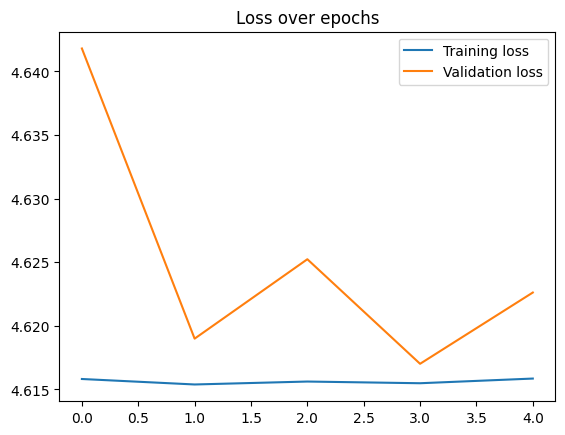

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [34]:
model.eval()
true_labels = []
predicted_labels = []

for images, labels in tqdm(test_loader, desc='Validation loop', miniters=50):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    , predicted = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

print(np.unique(true_labels))
print(np.unique(predicted_labels))

Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
[23 30 60 75]


In [35]:
torch.save(model, '/kaggle/working/pretrained_resnet_baseline.pth')

# 3. Checkpoint 1: Finetuning and Image Augmentation

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import random

seed_value = 10 #random seed representing our AI4ALL group no.  
random.seed(seed_value)

In [37]:
class FoodImageDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def get_class_counts(self): 
        return pd.Series(self.data.targets).value_counts()
    
    @property
    def classes(self):
        return self.data.classes

dataset = FoodImageDataset(data_dir = '../input/food41/images')
class_counts = dataset.get_class_counts()
len(dataset)

data_dir = '/kaggle/input/food41/images'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), # convert images to a PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/food41/images'
dataset = FoodImageDataset(data_dir, transform)

image, label = dataset[200] # check that any image is now a PyTorch Tensor
image.shape # check that size of the 3D tensor is correctly 224 x 224
for image, label in dataset:
    break
    
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
for images, labels in dataloader:
    break
images.shape, labels.shape
labels

tensor([10, 14, 70, 78, 35, 89, 31, 68, 95, 28, 35,  6,  4, 64, 83,  9, 49, 35,
        97, 44, 63, 12, 11, 59, 58, 62,  5, 67, 86, 41, 64, 88])

In [38]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size)
print(test_size)
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

80800
20200


In [39]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = torch.load('/kaggle/working/pretrained_resnet_baseline.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min',patience=3,factor=0.5)
criterion = nn.CrossEntropyLoss()


In [40]:
train_losses = []
test_losses = []
patience = 2
best_test_loss = float('inf')  
model.to(device)

num_epoch = 5
for epoch in range(num_epoch):
    #training model
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for images, labels in tqdm(train_loader, desc='Training loop', miniters=50):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}")
    
    model.eval()
    running_loss = 0.0
    correct = 0
    top5_correct = 0
    total = 0

    #testing model
    with torch.no_grad(): 
        for images, labels in tqdm(test_loader, desc='Validation loop', miniters=50): 
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * labels.size(0) 

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            _, top5_preds = outputs.data.topk(5, dim=1, largest=True, sorted=True)
            top5_preds = top5_preds.t()
            correct_top5 = top5_preds.eq(labels.view(-1).expand(5, -1))
            top5_correct += correct_top5.reshape(-1).float().sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    accuracy = 100 * (correct / total)
    top5_accuracy = 100 * (top5_correct / total)

    print("correct:",correct)
    print("total:",total)
    print('Accuracy on the test set: {}%'.format(accuracy)) 
    print('Top-5 Accuracy on the test set: {}%'.format(top5_accuracy))
    print(f'Test Loss: {test_loss:.4f}')
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience = 5  
    else:
        patience -= 1
        if patience == 0:
            print("Early stop")
            break 

Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.615904216813569


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 234
total: 20200
Accuracy on the test set: 1.1584158415841583%
Top-5 Accuracy on the test set: 5.217821782178218%
Test Loss: 4.6156


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 4.615987085446273


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 241
total: 20200
Accuracy on the test set: 1.193069306930693%
Top-5 Accuracy on the test set: 5.257425742574258%
Test Loss: 4.6316


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 4.615936550976026


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 228
total: 20200
Accuracy on the test set: 1.1287128712871286%
Top-5 Accuracy on the test set: 5.297029702970297%
Test Loss: 4.6180


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 4.615844158441713


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 233
total: 20200
Accuracy on the test set: 1.1534653465346534%
Top-5 Accuracy on the test set: 5.643564356435644%
Test Loss: 4.6175


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

KeyboardInterrupt: 

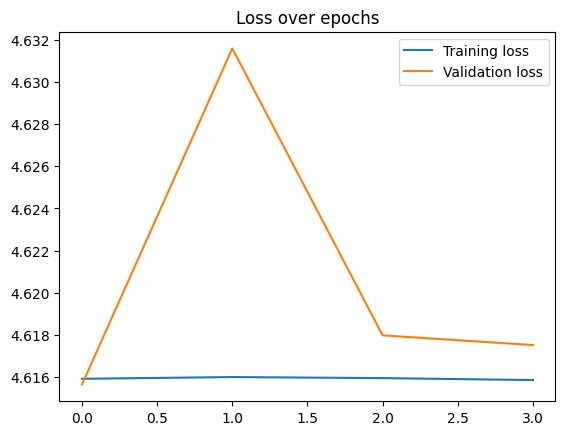

In [41]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

model.eval()
true_labels = []
predicted_labels = []

for images, labels in tqdm(test_loader, desc='Validation loop', miniters=50):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    , predicted = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

print(np.unique(true_labels))
print(np.unique(predicted_labels))

Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
[23 25 30 44]


# 4.Checkpoint 2: More Fine-Tuning

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import random


In [45]:
class FoodImageDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def get_class_counts(self): 
        return pd.Series(self.data.targets).value_counts()
    
    @property
    def classes(self):
        return self.data.classes

dataset = FoodImageDataset(data_dir = '../input/food41/images')
class_counts = dataset.get_class_counts()
len(dataset)

data_dir = '/kaggle/input/food41/images'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), # convert images to a PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/food41/images'
dataset = FoodImageDataset(data_dir, transform)

image, label = dataset[200] # check that any image is now a PyTorch Tensor
image.shape # check that size of the 3D tensor is correctly 224 x 224
for image, label in dataset:
    break
    
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
for images, labels in dataloader:
    break
images.shape, labels.shape
labels

tensor([12,  1, 12, 93, 55, 81, 85, 78, 63, 83,  1, 24, 77, 67, 94, 37, 56, 59,
        84, 66,  5, 63, 12, 87, 35, 55, 36, 34, 42, 54, 26,  5])

In [46]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size)
print(test_size)
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

80800
20200


In [56]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = timm.create_model('resnet50', pretrained=False, num_classes=101) 
model_state_dict = torch.load('/kaggle/working/best_model.pth', map_location=device) 
model.load_state_dict(model_state_dict)
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
model.layer4 = nn.Sequential(*[
    *list(model.layer4.children()), 
    nn.Dropout(p=0.2)
])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min',patience=3,factor=0.5)
criterion = nn.CrossEntropyLoss()

In [57]:
train_losses = []
test_losses = []
patience = 2
best_test_loss = float('inf')  
model.to(device)

num_epoch = 5
for epoch in range(num_epoch):
    #training model
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for images, labels in tqdm(train_loader, desc='Training loop', miniters=50):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}")
    
    model.eval()
    running_loss = 0.0
    correct = 0
    top5_correct = 0
    total = 0

    #testing model
    with torch.no_grad(): 
        for images, labels in tqdm(test_loader, desc='Validation loop', miniters=50): 
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images)
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * labels.size(0) 

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            _, top5_preds = outputs.data.topk(5, dim=1, largest=True, sorted=True)
            top5_preds = top5_preds.t()
            correct_top5 = top5_preds.eq(labels.view(-1).expand(5, -1))
            top5_correct += correct_top5.reshape(-1).float().sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    accuracy = 100 * (correct / total)
    top5_accuracy = 100 * (top5_correct / total)

    print("correct:",correct)
    print("total:",total)
    print('Accuracy on the test set: {}%'.format(accuracy)) 
    print('Top-5 Accuracy on the test set: {}%'.format(top5_accuracy))
    print(f'Test Loss: {test_loss:.4f}')
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience = 5  
    else:
        patience -= 1
        if patience == 0:
            print("Early stop")
            break 

Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.616035055429629


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 207
total: 20200
Accuracy on the test set: 1.0247524752475248%
Top-5 Accuracy on the test set: 4.653465346534653%
Test Loss: 4.6168


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 4.615971920183389


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 195
total: 20200
Accuracy on the test set: 0.9653465346534653%
Top-5 Accuracy on the test set: 4.826732673267327%
Test Loss: 4.6215


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 4.616145571340429


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 229
total: 20200
Accuracy on the test set: 1.1336633663366336%
Top-5 Accuracy on the test set: 5.03960396039604%
Test Loss: 4.6158


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 4.616020209269949


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 216
total: 20200
Accuracy on the test set: 1.0693069306930694%
Top-5 Accuracy on the test set: 4.881188118811881%
Test Loss: 4.6245


Training loop:   0%|          | 0/20200 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 4.616049611568451


Validation loop:   0%|          | 0/5050 [00:00<?, ?it/s]

correct: 216
total: 20200
Accuracy on the test set: 1.0693069306930694%
Top-5 Accuracy on the test set: 4.930693069306931%
Test Loss: 4.6172


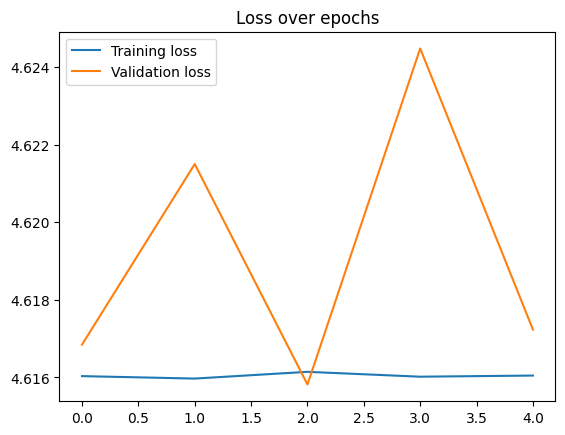

In [58]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()